## <div class="title_h2">Everything Counts - Assignment 2 - Nic Young</div>
### <div class="title_h3">https://github.com/nicc/lis-stats-2</div>
### <div class="title_h3">Do the number of trees in a London borough affect GCSE results?</div>
Null hypothesis (H0): The number of trees in a borough does not affect average GCSE results.

Alternate hypothessis (HA): The number of trees in a borough does affect average GCSE results.

We'll use a standard 95% confidence level.

According to a research paper in issue 181 of Landscape and Urban Planning, "A higher surrounding greenness contributes a better academic performance in students of all grades." (Leung et al., 2019, p. 181).

I want to investigate whether these results are substantiated by a higher GCSE average in London boroughs that contain more trees.

#### <div class="title_h4">Reference List:</div>
Leung, W. T. V., Tam, T. Y. T., Pan, W.-C., Wu, C.-D., Lung, S.-C. C., & Spengler, J. D. (2019). How is environmental greenness related to students’ academic performance in English and Mathematics? Landscape and Urban Planning, 181, 118-124. https://doi.org/10.1016/j.landurbplan.2018.09.021

## <div class="title_h2">Data Sources</div>
* the [Greater London Authority list of maintained trees](https://data.london.gov.uk/dataset/local-authority-maintained-trees) (July 2021)
* the [Department of Eduction GCSE results](https://data.london.gov.uk/dataset/gcse-results-by-borough) (2015 - 2023)
* the [Greater London Authority figures for Land Area and Population Density, Ward and Borough](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough) 2011


GCSEs: There is a separate csv file for each academic year. We'll use them all to get a more representative average for gcse results but note that we're using the tree count from 2021 only. This is not perfect.

Trees: Each row represents a single tree planted in the city of London. There are 817,150 total records. The data set was last updated in July 2021.

Land area: Each row represnts one year, with figures or projections for housing density and land area. We are only interested in land area.

## <div class="title_h2">Import common dependencies</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import seaborn as sns
sns.set()

## <div class="title_h2">Land area</div>

### <div class="title_h3">Loading and cleaning the data</div>

In [2]:
# load the data
area_data_file = './data/housing-density-borough.csv'
area_raw = pd.read_csv(area_data_file)

area_raw.head()

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1


In [3]:
# select relevant data
borough_sizes = area_raw.drop_duplicates(subset=['Name', 'Square_Kilometres'])[['Name', 'Square_Kilometres']]

borough_sizes.head()

,Name,Square_Kilometres
0,City of London,2.9
52,Barking and Dagenham,36.1
104,Barnet,86.7
156,Bexley,60.6
208,Brent,43.2
260,Bromley,150.1
312,Camden,21.8
364,Croydon,86.5
416,Ealing,55.5
468,Enfield,80.8


## <div class="title_h2">GCSEs</div>

### <div class="title_h3">Data overview</div>

Available variables:
| variable                                                 | description                                                                             |
| -------------------------------------------------------- | --------------------------------------------------------------------------------------- |
| `Code`                                                   | Borough area code.                                                                      |
| `Area`                                                   | Borough name.                                                                           |
| `Number of pupils at the end of key stage 4`             | The number of pupils included in the grade average.                                     |
| `Average Attainment 8 score per pupil`                   | Average GCSE score.                                                                     |
| `Percentage of pupils entered for components`            | English and maths GCSEs: Unsure. I am not familiar with the GCSE grading system.        |
| `Percentage of pupils who achieved a strong 9-5 pass`    | English and maths GCSEs: Percentage of pupils who attained a strong pass (above 5).     |
| `Percentage of pupils who achieved a standard 9-4 pass`  | English and maths GCSEs: Percentage of pupiles who attained a standard pass (above 4).  |
| `Year`                                                   | Added when merging data files. It's the calendar year at the end of the academic year.  |

These variables are individually available for all students, girls, and boys. We are interested in all students. We have a separate file for each academic year.

Unfortunately, the data is presented in an awkward format for the purpose of computational analysis. As such, I have made a copy of each file with the duplicated boys and girls sections removed as they result in ambiguous named column indeces. The duplicated files we'll work from are called `./data/GCSE_results/<year>_clean.csv`. They includes the above variables for all students only.

### <div class="title_h3">Loading and cleaning the data</div>

In [4]:
# load the data from a different csv file for every year, and add a 'year' column for each.
gcses_16 = pd.read_csv('./data/GCSE_results/2015-16_clean.csv')
gcses_16['Year'] = '2016'

gcses_17 = pd.read_csv('./data/GCSE_results/2016-17_clean.csv')
gcses_17['Year'] = '2017'

gcses_18 = pd.read_csv('./data/GCSE_results/2017-18_clean.csv')
gcses_18['Year'] = '2018'

gcses_19 = pd.read_csv('./data/GCSE_results/2018-19_clean.csv')
gcses_19['Year'] = '2019'

gcses_20 = pd.read_csv('./data/GCSE_results/2019-20_clean.csv')
gcses_20['Year'] = '2020'

gcses_21 = pd.read_csv('./data/GCSE_results/2020-21_clean.csv')
gcses_21['Year'] = '2021'

gcses_22 = pd.read_csv('./data/GCSE_results/2021-22_clean.csv')
gcses_22['Year'] = '2022'

gcses_23 = pd.read_csv('./data/GCSE_results/2022-23_clean.csv')
gcses_23['Year'] = '2023'

# concatenate them all into a single dataframe
gcses_raw = pd.concat([gcses_16, gcses_17, gcses_18, gcses_19, gcses_20, gcses_21, gcses_22, gcses_23], ignore_index=True)

gcses_raw.head()

,Code,Area,Number of pupils at the end of key stage 4,Average Attainment 8 score per pupil,Average Progress 8 score per pupil,Year
0,E09000002,Barking and Dagenham,2201,49.7,0.15,2016
1,E09000003,Barnet,3647,56.1,0.33,2016
2,E09000004,Bexley,3192,52.2,-0.04,2016
3,E09000005,Brent,3035,51.5,0.31,2016
4,E09000006,Bromley,3305,53.7,0.1,2016


In [5]:
# basic data
gcses_by_borough = gcses_raw[['Code', 'Area', 'Average Attainment 8 score per pupil', 'Year']]

# make boroughs categorical and sort them for display as point plots
gcses_by_borough['Area'] = pd.Categorical(gcses_by_borough['Area'], ordered=True, categories=gcses_by_borough['Area'].unique())
gcses_by_borough = gcses_by_borough.sort_values(['Year', 'Area'])

gcses_by_borough.head()

,Code,Area,Average Attainment 8 score per pupil,Year
0,E09000002,Barking and Dagenham,49.7,2016
1,E09000003,Barnet,56.1,2016
2,E09000004,Bexley,52.2,2016
3,E09000005,Brent,51.5,2016
4,E09000006,Bromley,53.7,2016


### <div class="title_h3">Exploratory analysis</div>

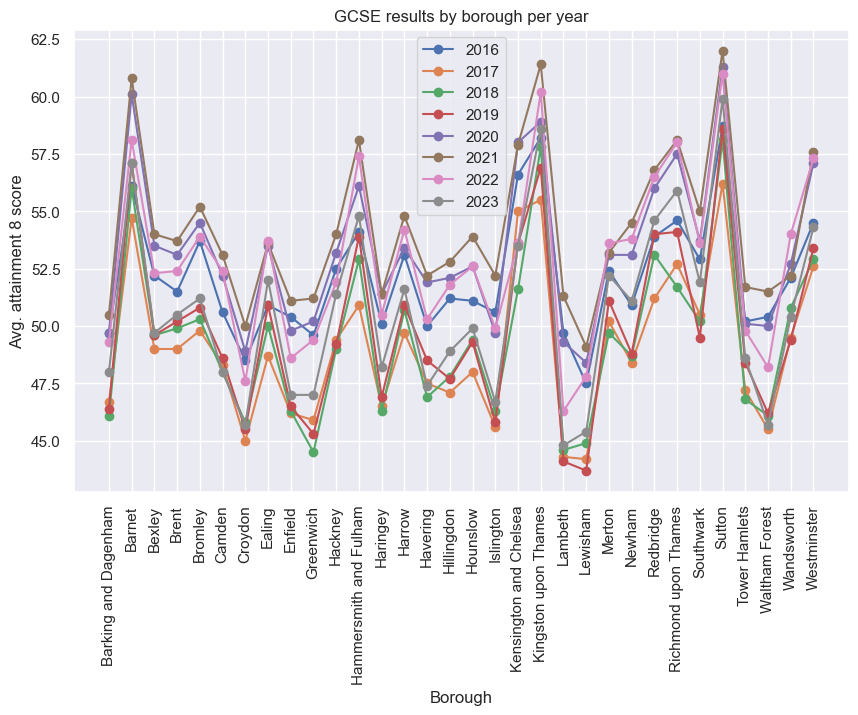

In [6]:
# let's view GCSE results per year as a line chart
plt.figure(figsize=(10, 6))

# group the data by year and plot each group
for year, group in gcses_by_borough.groupby('Year'):
    plt.plot(group['Area'], group['Average Attainment 8 score per pupil'], marker='o', label=f"{year}")

plt.title('GCSE results by borough per year')
plt.xlabel('Borough')
plt.ylabel('Avg. attainment 8 score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)

plt.show()

## <div class="title_h2">Trees</div>

### <div class="title_h3">Data overview</div>

Available variables:
| variable         | description |
| --------------------------- | ------------|
| `objectid`                  | record identifier. |
| `borough`                   | The borough of London in which the tree resides. |
| `gla_tree_name`             | The display name used for navigating the Greater London Authority tree map. |
| `tree_name`                 | Unsure. This appears to be an uncleaned version of gla_tree_name. |
| `taxon_name`                | Botanical name. This is the most specific identifier of the "same" tree across records. |
| `common_name`               | Common name. |
| `age`                       | This variable is messy and not reliable. See age_group below. |
| `age_group`                 | This classifies each tree as being in a specific age range. Options are: 'Young (0-15)', 'Early mature (16-30)', 'Mature (31-80)', 'Over mature (81-150)', and 'Veteran (over 150)'. Some are undefined. |
| `heigh_m`                   | Height in meters. This variable is sparsely populated and inconsistent in format. |
| `spread_m`                  | Canopy spread in meters. This variable is sparsely populated. |
| `canopy_spread_group`       | This classifies each tree as being in a specific range of canopy spread (in meters). Options are: '00 to 05m', '05 to 10m', '10 to 15m', and '15 to 20m'. Some are undefined. |
| `diameter_at_breast_height` | Diameter at breast height in meters. This variable is sparsely populated. |
| `dbh_group`                 | This classifies each tree as being in a specific range of diameter at breast height (in meters). Options are: '21 to 40cm', '41 to 70cm', '11 to 20cm', 'Upto 10cm', and '70cm+'. This variable is sparsely populated. |
| `longitude`                 | The longitudinal location of the tree. |
| `latitude`                  | The latitudinal location of the tree. |
| `condition`                 | The condition of the tree. Options are: 'Reasonable', 'Good', 'Poor', and 'Dead'. Data only available for Kingston Upon Thames |
| `load_data`                 | The date the tree was first recorded. |
| `updated`                   | The date the tree was last updated. |

### <div class="title_h3">Loading and cleaning the data</div>

In [7]:
# load the data
trees_data_file = './data/Borough_tree_list_2021July.csv'
trees_raw = pd.read_csv(trees_data_file)

# remove records that are not identified as species (this includes tree stumps, for example)
trees_data = trees_raw[~trees_raw['taxon_name'].str.lower().str.startswith('zz', na=True)].sort_values('taxon_name')

# remove 'Out' from boroughs
trees_data = trees_data[trees_data['borough'] != 'Out']

trees_data.head()

,objectid,borough,gla_tree_name,tree_name,taxon_name,common_name,age,age_group,height_m,spread_m,canopy_spread_group,diameter_at_breast_height_cm,dbh_group,longitude,latitude,condition,load_date,updated
549678,549679,Lewisham,Pine,Pine,Abies,Fir,1 young,Young (0-15),NaN,NaN,NaN,NaN,NaN,0.000761,51.461473,NaN,20200928,20210715
549676,549677,Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.013610,51.470342,NaN,20200928,20210715
549677,549678,Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.013580,51.470368,NaN,20200928,20210715
549679,549680,Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.031632,51.457732,NaN,20200928,20210715
549680,549681,Lewisham,Pine,Pine,Abies,Fir,1 mature,Mature (31-80),NaN,NaN,NaN,NaN,NaN,-0.032205,51.457814,NaN,20200928,20210715


In [8]:
trees_data.describe()

,objectid,spread_m,diameter_at_breast_height_cm,longitude,latitude,load_date,updated
count,762394.000000,100372.000000,208115.000000,762394.000000,762394.000000,7.623940e+05,762394.0
mean,405499.762893,5.406437,28.210981,-0.118732,51.515094,2.018907e+07,20210715.0
std,236376.677611,3.386238,29.892352,0.153487,0.083844,1.057118e+04,0.0
min,1.000000,0.100000,1.000000,-0.497710,51.301373,2.018021e+07,20210715.0
25%,194578.250000,3.000000,10.000000,-0.231540,51.453939,2.018021e+07,20210715.0
50%,421213.500000,5.000000,21.000000,-0.092263,51.513677,2.018021e+07,20210715.0
75%,611817.750000,7.000000,37.000000,0.000884,51.582418,2.020093e+07,20210715.0
max,817150.000000,29.000000,850.000000,0.286538,51.684488,2.021032e+07,20210715.0


In [9]:
# group by borough
trees_by_borough = trees_data.groupby('borough', as_index=False).size()
trees_by_borough.head()

,borough,size
0,Barking and Dagenham,19923
1,Barnet,29723
2,Bexley,11699
3,Brent,261
4,Bromley,65256


### <div class="title_h3">Exploratory analysis</div>

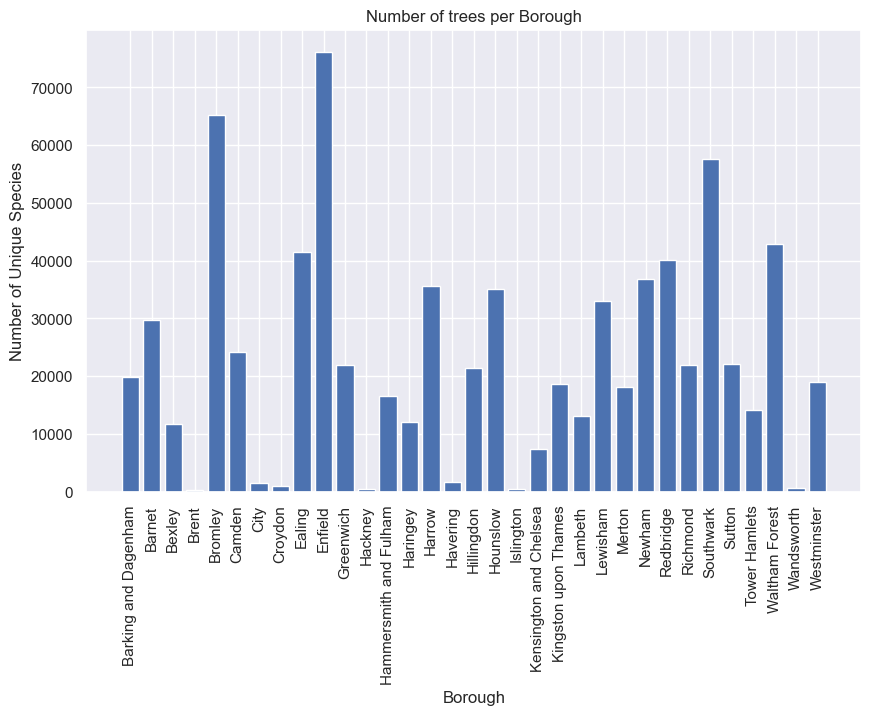

In [10]:
# bar chart
plt.figure(figsize=(10, 6))
plt.bar(trees_by_borough['borough'], trees_by_borough['size'])

plt.title('Number of trees per Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Unique Species')
plt.xticks(rotation=90)

plt.show()

There's a problem here. I know Hackney has a lot more trees than that, and I'm sure the other very low values are incorrect too. This is the official data so it's the best we've got.

## <div class="title_h2">Combining the data</div>
We need a common reference to connect the data sets. Since the data are from the same source, we are fortunate to be able to rely on borough name (mostly). We do have a little cleaning to do though.

In [11]:

# we have some mismatches and a groupby artefact to sort out...
borough_sizes.rename(columns={'Name': 'borough', 'Square_Kilometres': 'sqkm'}, inplace=True)

gcses_by_borough.rename(columns={'Area': 'borough', 'Average Attainment 8 score per pupil': 'gcses', 'Year': 'year'}, inplace=True)

trees_by_borough.rename(columns={'size': 'trees'}, inplace=True)
trees_by_borough.loc[trees_by_borough['borough'] == 'Richmond', 'borough'] = 'Richmond upon Thames'

# let's make a new dataframe to consolidate borough size, gcse results and tree counts
merged = pd.merge(gcses_by_borough, trees_by_borough, on='borough', how='left')
merged = pd.merge(merged, borough_sizes, on='borough', how='left')

# we don't have good data for London City so let's remove that
merged = merged[merged['borough'] != 'City']

# make boroughs categorical and sort them for display as point plots
merged['borough'] = pd.Categorical(merged['borough'], ordered=True, categories=merged['borough'].unique())
merged = merged.sort_values(['year', 'borough'])

merged.head()

,Code,borough,gcses,year,trees,sqkm
0,E09000002,Barking and Dagenham,49.7,2016,19923,36.1
1,E09000003,Barnet,56.1,2016,29723,86.7
2,E09000004,Bexley,52.2,2016,11699,60.6
3,E09000005,Brent,51.5,2016,261,43.2
4,E09000006,Bromley,53.7,2016,65256,150.1


Okay let's make tree count relative to area...

In [12]:
merged['tree_density'] = round(merged['trees'] / merged['sqkm'], 2)

merged.head()

,Code,borough,gcses,year,trees,sqkm,tree_density
0,E09000002,Barking and Dagenham,49.7,2016,19923,36.1,551.88
1,E09000003,Barnet,56.1,2016,29723,86.7,342.83
2,E09000004,Bexley,52.2,2016,11699,60.6,193.05
3,E09000005,Brent,51.5,2016,261,43.2,6.04
4,E09000006,Bromley,53.7,2016,65256,150.1,434.75


Let's look at this...

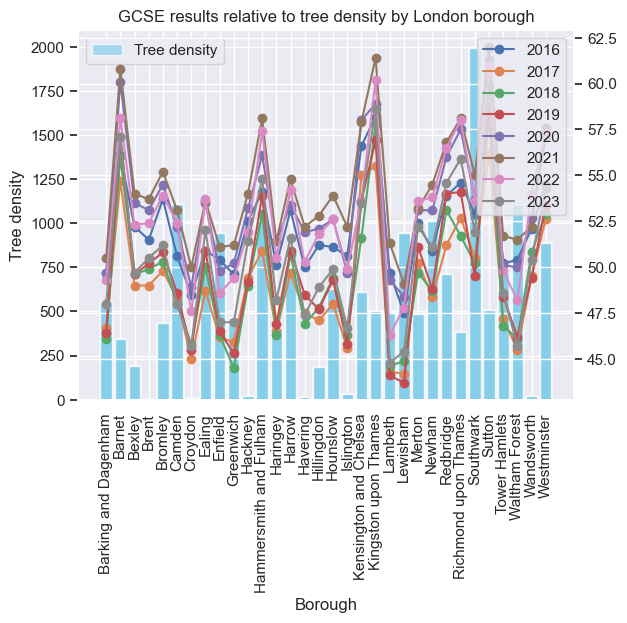

In [13]:
fig, tree_density_axis = plt.subplots() # what's fig all about here?. should I set a size?
plt.xticks(rotation=90)

tree_density_axis.bar(merged['borough'], merged['tree_density'], color='skyblue', label='Tree density', alpha=0.7)
tree_density_axis.set_xlabel('Borough')
tree_density_axis.set_ylabel('Tree density')
tree_density_axis.set_title('GCSE results relative to tree density by London borough')

gcse_axis = tree_density_axis.twinx()

# group by year and plot each group
for year, group in gcses_by_borough.groupby('year'):
    gcse_axis.plot(group['borough'], group['gcses'], marker='o', label=f"{year}")

tree_density_axis.legend(loc='upper left')
gcse_axis.legend(loc='upper right')

plt.show()

That's a bit busy but still helpful. Just looking at it, there does not appear to be a correlation. Let's continue anyway.

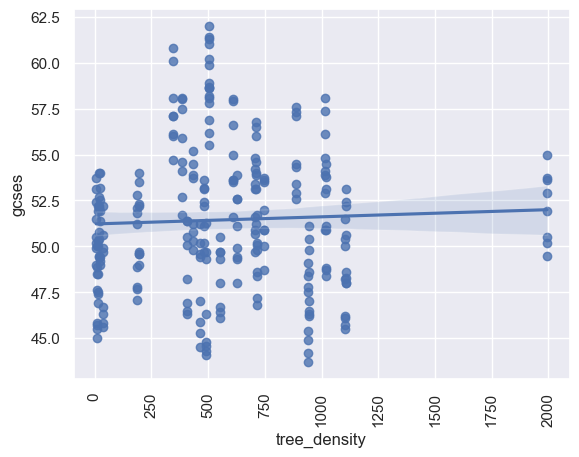

In [14]:
sns.regplot(data=merged, x='tree_density', y='gcses', scatter=True)

plt.xticks(rotation=90)
plt.show()

Our regression line is pretty much flat. This substantiates that there is no correlation.

In [15]:
# Since we're comparing oridinal values we'll use an ordinary linear squares regression test
regression = smf.ols('gcses ~ tree_density', data=merged).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gcses   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4648
Date:                Tue, 29 Oct 2024   Prob (F-statistic):              0.496
Time:                        21:33:13   Log-Likelihood:                -708.78
No. Observations:                 256   AIC:                             1422.
Df Residuals:                     254   BIC:                             1429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.2213      0.404    126.673      0.000      50.425      52.018
tree_density     0.0004      0.001      0.682      0.496      -0.001       0.002
==============================================================================
Omnibus:                        6.708   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.926
Skew:                           0.391   Prob(JB):                       0.0313
Kurtosis:                       2.806   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## <div class="title_h2">Conclusion</div>
And here we have it confirmed.

The key outputs here are R-squared and the tree_density p-value.

An R-squared of 0.002 tells us that only 0.2% of GCSE result variance is explained by tree density. This is not a lot.

A p-value of 0.496 is very high. This means that there's a 49.6% probability that these results are observable whilst the null hypothesis holds true. This is defintiely not enough to reject the null hypothesis. 

In order to reject the null hypothesis, we would need a p-value less than 0.05 (less than 5% probability of observing these results under the null hypothesis). This is clearly not the case.

**We therefore do not reject the null hypothesis. We cannot say that there is statistically discernable evidence that the number of trees in a borough affects GCSE results.**

